# Behavioral Cloning With MXNet

This notebook walks through how we can create a model to predict the streeting angle from an image captured through the Pi camera of a robocar. For details on how to build the car itself visit www.donkeycar.com

The images have been captured data from the camera mounted over the car. Each image is captured with the the throttle data and the steering angle. We construct a Convolutional Neural Network (CNN) to mimic the behavior of the training data and predict the steering angle given an image.


# Download the RecordIO files which have the image data

For ease of use I have already converted the image dataset with labels in to MXNet RecordIO format and split in to train and test sets

In [ ]:
!wget https://s3.amazonaws.com/smallya-test/mxnet-behavioral-cloning/train.rec

!wget https://s3.amazonaws.com/smallya-test/mxnet-behavioral-cloning/valid.rec

In [3]:
import mxnet as mx
import numpy as np

import logging
head = '%(asctime)-15s %(message)s'
logging.basicConfig(level=logging.DEBUG, format=head)

#load 
def get_iterators(batch_size, data_shape=(3, 120, 160)):
    train = mx.io.ImageRecordIter(
        path_imgrec         = 'train.rec', 
        data_name           = 'data',
        label_name          = 'softmax_label',
        batch_size          = batch_size,
        data_shape          = data_shape,
        shuffle             = True,
        rand_crop           = True,
        rand_mirror         = True)
    val = mx.io.ImageRecordIter(
        path_imgrec         = 'valid.rec',
        data_name           = 'data',
        label_name          = 'softmax_label',
        batch_size          = batch_size,
        data_shape          = data_shape,
        rand_crop           = False,
        rand_mirror         = False)
    return (train, val)

batch_size = 16
train_iter, val_iter = get_iterators(batch_size)

# Define the model

In [4]:
data = mx.symbol.Variable(name="data")

body = mx.sym.Convolution(data=data, num_filter=24,  kernel=(5, 5), stride=(2,2), no_bias=True, name="conv1")
body = mx.sym.Activation(data=body, act_type='relu', name='relu1')
body = mx.symbol.Pooling(data=body, kernel=(2, 2), stride=(2,2), pool_type='max')

body = mx.sym.Convolution(data=data, num_filter=32,  kernel=(5, 5), stride=(2,2), no_bias=True, name="conv2")
body = mx.sym.Activation(data=body, act_type='relu', name='relu2')
body = mx.symbol.Pooling(data=body, kernel=(2, 2), stride=(2,2), pool_type='max')

body = mx.sym.Convolution(data=data, num_filter=32,  kernel=(5, 5), stride=(2,2), no_bias=True, name="conv3")
body = mx.sym.Activation(data=body, act_type='relu', name='relu3')
body = mx.symbol.Pooling(data=body, kernel=(2, 2), stride=(2,2), pool_type='max')
  
flatten = mx.symbol.Flatten(data=body)
#body = mx.sym.Dropout(data=body, p=0.1)

body = mx.symbol.FullyConnected(data=flatten, name='fc0', num_hidden=32)
body = mx.sym.Activation(data=body, act_type='relu', name='relu6')
body = mx.sym.Dropout(data=body, p=0.1)

body = mx.symbol.FullyConnected(data=body, name='fc1', num_hidden=16)
body = mx.sym.Activation(data=body, act_type='relu', name='relu7')

out = mx.symbol.FullyConnected(data=body, name='fc2', num_hidden=1)
out = mx.symbol.LinearRegressionOutput(data=out, name="softmax")

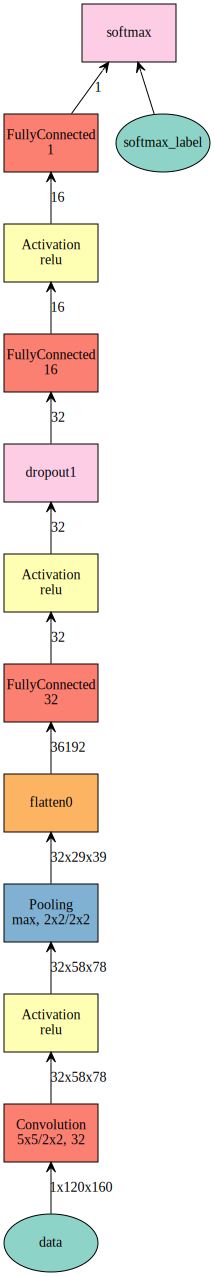

In [5]:
#(batch_size, NUM_CHANNELS, HEIGHT, WIDTH)
shape = {"data" : (16, 1, 120, 160)}
mx.viz.plot_network(symbol=out, shape=shape)

In [7]:
### 2. build a basic model

batch_size = 8
num_gpus = 1
num_epoch = 10
mod = mx.mod.Module(out, context=[mx.gpu(i) for i in range(num_gpus)])
mod.fit(train_data=train_iter, 
        eval_data=val_iter, 
        eval_metric='mae', 
        optimizer='rmsprop',
        optimizer_params={'learning_rate': 0.0009},
        num_epoch=num_epoch,
        batch_end_callback = mx.callback.Speedometer(batch_size, 100),        
       )

2017-09-22 23:35:44,528 Epoch[0] Batch [100]	Speed: 1757.42 samples/sec	Train-mae=0.186693
2017-09-22 23:35:45,429 Epoch[0] Batch [200]	Speed: 889.96 samples/sec	Train-mae=0.167489
2017-09-22 23:35:45,793 Epoch[0] Batch [300]	Speed: 2204.25 samples/sec	Train-mae=0.176916
2017-09-22 23:35:46,691 Epoch[0] Batch [400]	Speed: 892.20 samples/sec	Train-mae=0.168915
2017-09-22 23:35:47,054 Epoch[0] Batch [500]	Speed: 2212.41 samples/sec	Train-mae=0.178530
2017-09-22 23:35:47,928 Epoch[0] Batch [600]	Speed: 915.94 samples/sec	Train-mae=0.168207
2017-09-22 23:35:48,290 Epoch[0] Batch [700]	Speed: 2216.18 samples/sec	Train-mae=0.148003
2017-09-22 23:35:48,709 Epoch[0] Train-mae=0.146447
2017-09-22 23:35:48,710 Epoch[0] Time cost=4.664
2017-09-22 23:35:49,028 Epoch[0] Validation-mae=0.127190
2017-09-22 23:35:49,888 Epoch[1] Batch [100]	Speed: 2223.97 samples/sec	Train-mae=0.138936
2017-09-22 23:35:50,685 Epoch[1] Batch [200]	Speed: 1005.68 samples/sec	Train-mae=0.140325
2017-09-22 23:35:51,045 Ep

In [8]:
# Helper function to convert iterator to list for augmenting data

def iter_to_ndarray(data_iter):
    '''
    @ returns data array and label array
    '''
    data_iter.reset()

    from collections import namedtuple
    Batch = namedtuple('Batch', ['data'])

    data = []
    labels = []
    
    for it in enumerate(val_iter):
        for datum, l in zip(it[1].data[0], it[1].label[0]):
            data.append(datum)
            labels.append(l)
    return data, labels

In [32]:
# Save the model
prefix = 'my-car'
mc = mod.save_checkpoint(prefix, num_epoch)

2017-08-02 19:56:53,587 Saved checkpoint to "my-car-0010.params"


In [10]:
# Load the model ;  

sym, arg_params, aux_params = mx.model.load_checkpoint('my-car', num_epoch)
mod = mx.mod.Module(symbol=sym)

In [11]:
# Testing the model
from PIL import Image
import numpy as np

dshape = [('data', (1,3,120,160))]
mod.bind(for_training=False, data_shapes=dshape)
mod.set_params(arg_params, aux_params)

/home/ubuntu/mxnet/python/mxnet/module/base_module.py:64: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


expect: 0.11115, pred: 0.03378, diff: 0.07737
expect: 0.10741, pred: 0.05245, diff: 0.05495
expect: -0.06599, pred: -0.07364, diff: 0.00764


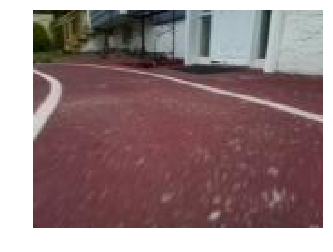

In [17]:
import numpy as np
from PIL import Image
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

import cv2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

imgs = [
        'frame_00135_ttl_0.2479085339356424_agl_0.11114842857855993_mil_0.0.jpg',
        'frame_00126_ttl_0.25_agl_0.10740846691566244_mil_0.0.jpg',
        'frame_00140_ttl_0.25_agl_-0.06599178170093933_mil_0.0.jpg'
       ]

path = "./sample_data/"

for i in range(len(imgs)):
    
    img_loc = path + imgs[i]
    
    # pre process image
    img = Image.open(img_loc)
    img = np.array(img)
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2) 
    img = img[np.newaxis, :] 

    mod.forward(Batch(data=[mx.nd.array(img)]))
    angle = mod.get_outputs()[0].asnumpy()[0]
    exp = float(imgs[i].split('_')[5])
    diff = exp - angle[0]
    print "expect: %.5f, pred: %.5f, diff: %.5f" %(exp , angle[0], diff)
    
    img = cv2.imread(img_loc)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

For more info on the topic: https://medium.com/@ksakmann/behavioral-cloning-make-a-car-drive-like-yourself-dc6021152713